In [1]:
import kagglehub
asdasdasasdas_garbage_classification_path = kagglehub.dataset_download('asdasdasasdas/garbage-classification')
mostafaabla_garbage_classification_path = kagglehub.dataset_download('mostafaabla/garbage-classification')

print('Data source import complete.')


Data source import complete.


# <a id="1"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">1. Setup</div>

<a id="1.1"></a>
# <b><span style='color:#8D6D9B'>1.1. Package and Library</span></b>

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.style.use('ggplot')

<a id="1.2"></a>
# <b><span style='color:#8D6D9B'>1.2. Load The Data</span></b>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/Datasets/Waste_Classification.zip"
extract_path = "/content/Waste_Classification"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
import os
os.listdir('/content/Waste_Classification')

['garbage_classification']

In [6]:
dataDirList = "/content/Waste_Classification/garbage_classification/"

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']

In [7]:
import pandas as pd

dataDir = os.path.join(extract_path, 'garbage_classification')

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic', 'white-glass']

imgPaths = []
labels = []

for className in os.listdir(dataDir):
    if className in selectedClasses:
        classPath = os.path.join(dataDir, className)
        for img in os.listdir(classPath):
            imgPath = os.path.join(classPath, img)
            imgPaths.append(imgPath)

            if className == 'white-glass':
                labels.append('glass')
            else:
                labels.append(className)

df = pd.DataFrame({
    'imgPath': imgPaths,
    'label': labels
})

df = df.sample(frac=1).reset_index(drop=True)

df.head()

df['label'].value_counts()


label
paper        1050
cardboard     891
plastic       865
glass         775
metal         769
trash         697
Name: count, dtype: int64

# <a id="2"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">2. Spliting</div>

In [8]:
def DataFrameSpliting(df , ratio , classesList):

    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)

    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [9]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

In [10]:
trainDf

imgPath  label
0     /content/Waste_Classification/garbage_classifi...  trash
1     /content/Waste_Classification/garbage_classifi...  metal
2     /content/Waste_Classification/garbage_classifi...  metal
3     /content/Waste_Classification/garbage_classifi...  glass
4     /content/Waste_Classification/garbage_classifi...  paper
...                                                 ...    ...
4282  /content/Waste_Classification/garbage_classifi...  metal
4283  /content/Waste_Classification/garbage_classifi...  paper
4284  /content/Waste_Classification/garbage_classifi...  trash
4285  /content/Waste_Classification/garbage_classifi...  trash
4286  /content/Waste_Classification/garbage_classifi...  paper

[4287 rows x 2 columns]

In [11]:
trainDf['label'].value_counts()

label
paper        892
cardboard    757
plastic      735
glass        658
metal        653
trash        592
Name: count, dtype: int64

In [12]:
testDf

imgPath    label
0    /content/Waste_Classification/garbage_classifi...    metal
1    /content/Waste_Classification/garbage_classifi...    glass
2    /content/Waste_Classification/garbage_classifi...    glass
3    /content/Waste_Classification/garbage_classifi...    paper
4    /content/Waste_Classification/garbage_classifi...  plastic
..                                                 ...      ...
755  /content/Waste_Classification/garbage_classifi...    metal
756  /content/Waste_Classification/garbage_classifi...    paper
757  /content/Waste_Classification/garbage_classifi...  plastic
758  /content/Waste_Classification/garbage_classifi...    metal
759  /content/Waste_Classification/garbage_classifi...    trash

[760 rows x 2 columns]

In [13]:
testDf['label'].value_counts()

label
paper        158
cardboard    134
plastic      130
glass        117
metal        116
trash        105
Name: count, dtype: int64

# <a id="3"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">3. Data Explorations</div>

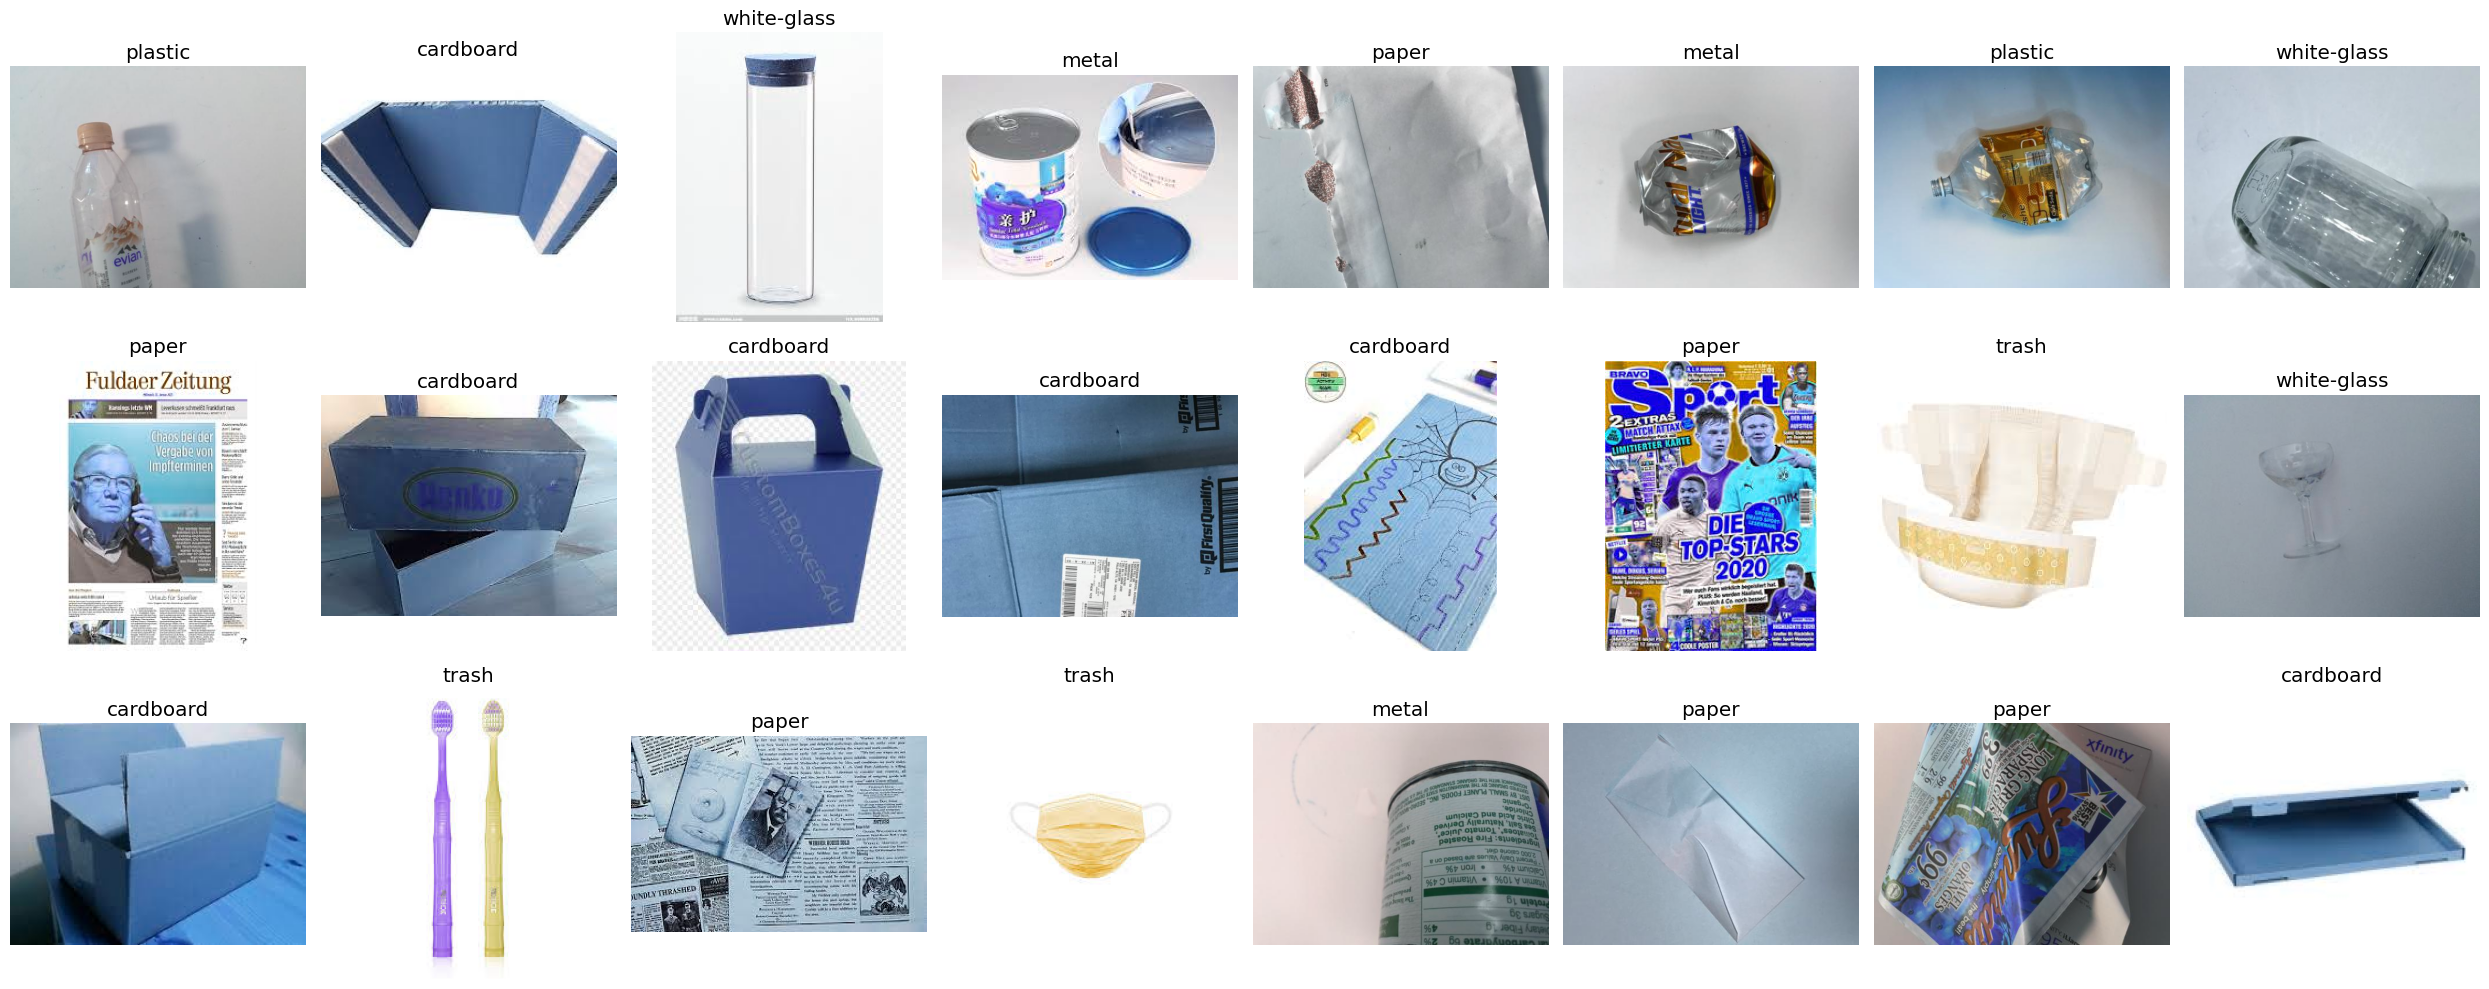

In [14]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

# <a id="4"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">4. Data Augmentation</div>

In [15]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [16]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 4287 validated image filenames belonging to 6 classes.
Found 760 validated image filenames belonging to 6 classes.
Training set size: 4287
Testing set size: 760


# <a id="5"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">5. Modeling </div>

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

with tf.device('/GPU:0'):
    Model = Sequential([
        MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='softmax')

    ])



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-40]:
    layer.trainable = False


In [20]:
from tensorflow.keras.losses import CategoricalCrossentropy

Model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])


callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint("best_garbage_model.keras", save_best_only=True)
]


In [21]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(trainGenerator.classes),
    y=trainGenerator.classes
)
class_weights = dict(enumerate(class_weights))


In [22]:
history = Model.fit(trainGenerator,
                    validation_data=testGenerator,
                    epochs=50,
                    callbacks=callbacks,
                    class_weight=class_weights)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.3257 - loss: 2.1645 - val_accuracy: 0.5658 - val_loss: 1.3154 - learning_rate: 1.0000e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 58s 867ms/step - accuracy: 0.6185 - loss: 1.2631 - val_accuracy: 0.6855 - val_loss: 1.0747 - learning_rate: 1.0000e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 843ms/step - accuracy: 0.7372 - loss: 1.0573 - val_accuracy: 0.7211 - val_loss: 1.0072 - learning_rate: 1.0000e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 833ms/step - accuracy: 0.7962 - loss: 0.9345 - val_accuracy: 0.7197 - val_loss: 1.0123 - learning_rate: 1.0000e-04
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 830ms/step - accuracy: 0.8199 - loss: 0.9013 - val_accuracy: 0.7316 - val_loss: 1.0538 - learning_rate: 1.0000e-04
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 831ms/step - accuracy: 0.8348 - loss: 0.8611 - val_accuracy: 0.7079 - val_loss: 1.1161 - learning_rate: 1.0000e-04
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 57s 856ms/step - accura

In [23]:
Model.summary()
Model.save("garbageClassification_model.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,139,924 (23.42 MB)

 Trainable params: 1,854,406 (7.07 MB)

 Non-trainable params: 576,704 (2.20 MB)

 Optimizer params: 3,708,814 (14.15 MB)

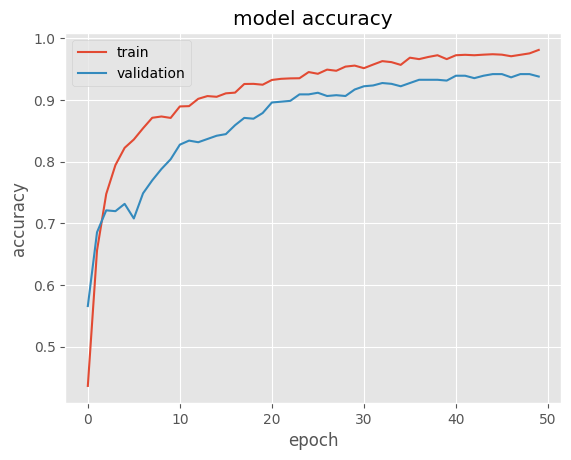

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# <a id="6"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">6. Evaluation</div>

In [25]:
predictions = Model.predict(testGenerator)

95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step


In [26]:
trainGenerator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [27]:
trueClasses = testGenerator.classes
trueClasses[:10]

[2, 1, 1, 3, 4, 0, 2, 0, 0, 2]

In [28]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([2, 2, 1, 3, 4, 3, 2, 0, 0, 2])

In [29]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9247 - loss: 0.6330


0.9381579160690308

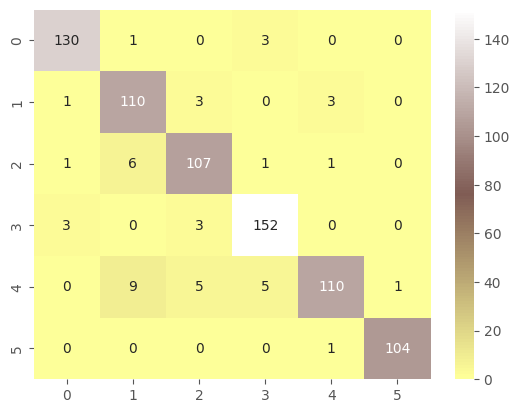

In [30]:
CM = confusion_matrix(trueClasses, predictedClasses)
sns.heatmap(CM, center = True,cmap='terrain',annot=True ,fmt='.5g')
plt.show()

In [31]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       134
           1       0.87      0.94      0.91       117
           2       0.91      0.92      0.91       116
           3       0.94      0.96      0.95       158
           4       0.96      0.85      0.90       130
           5       0.99      0.99      0.99       105

    accuracy                           0.94       760
   macro avg       0.94      0.94      0.94       760
weighted avg       0.94      0.94      0.94       760



# <a id="7"></a>
<div style="padding:10px;
            color:white;
            margin:5;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:15px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700">7. Predicted Images</div>

In [32]:

images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)
    true_class_idx = np.argmax(true_labels_batch[0])

    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])

    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]

    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)

    if i >= 24:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


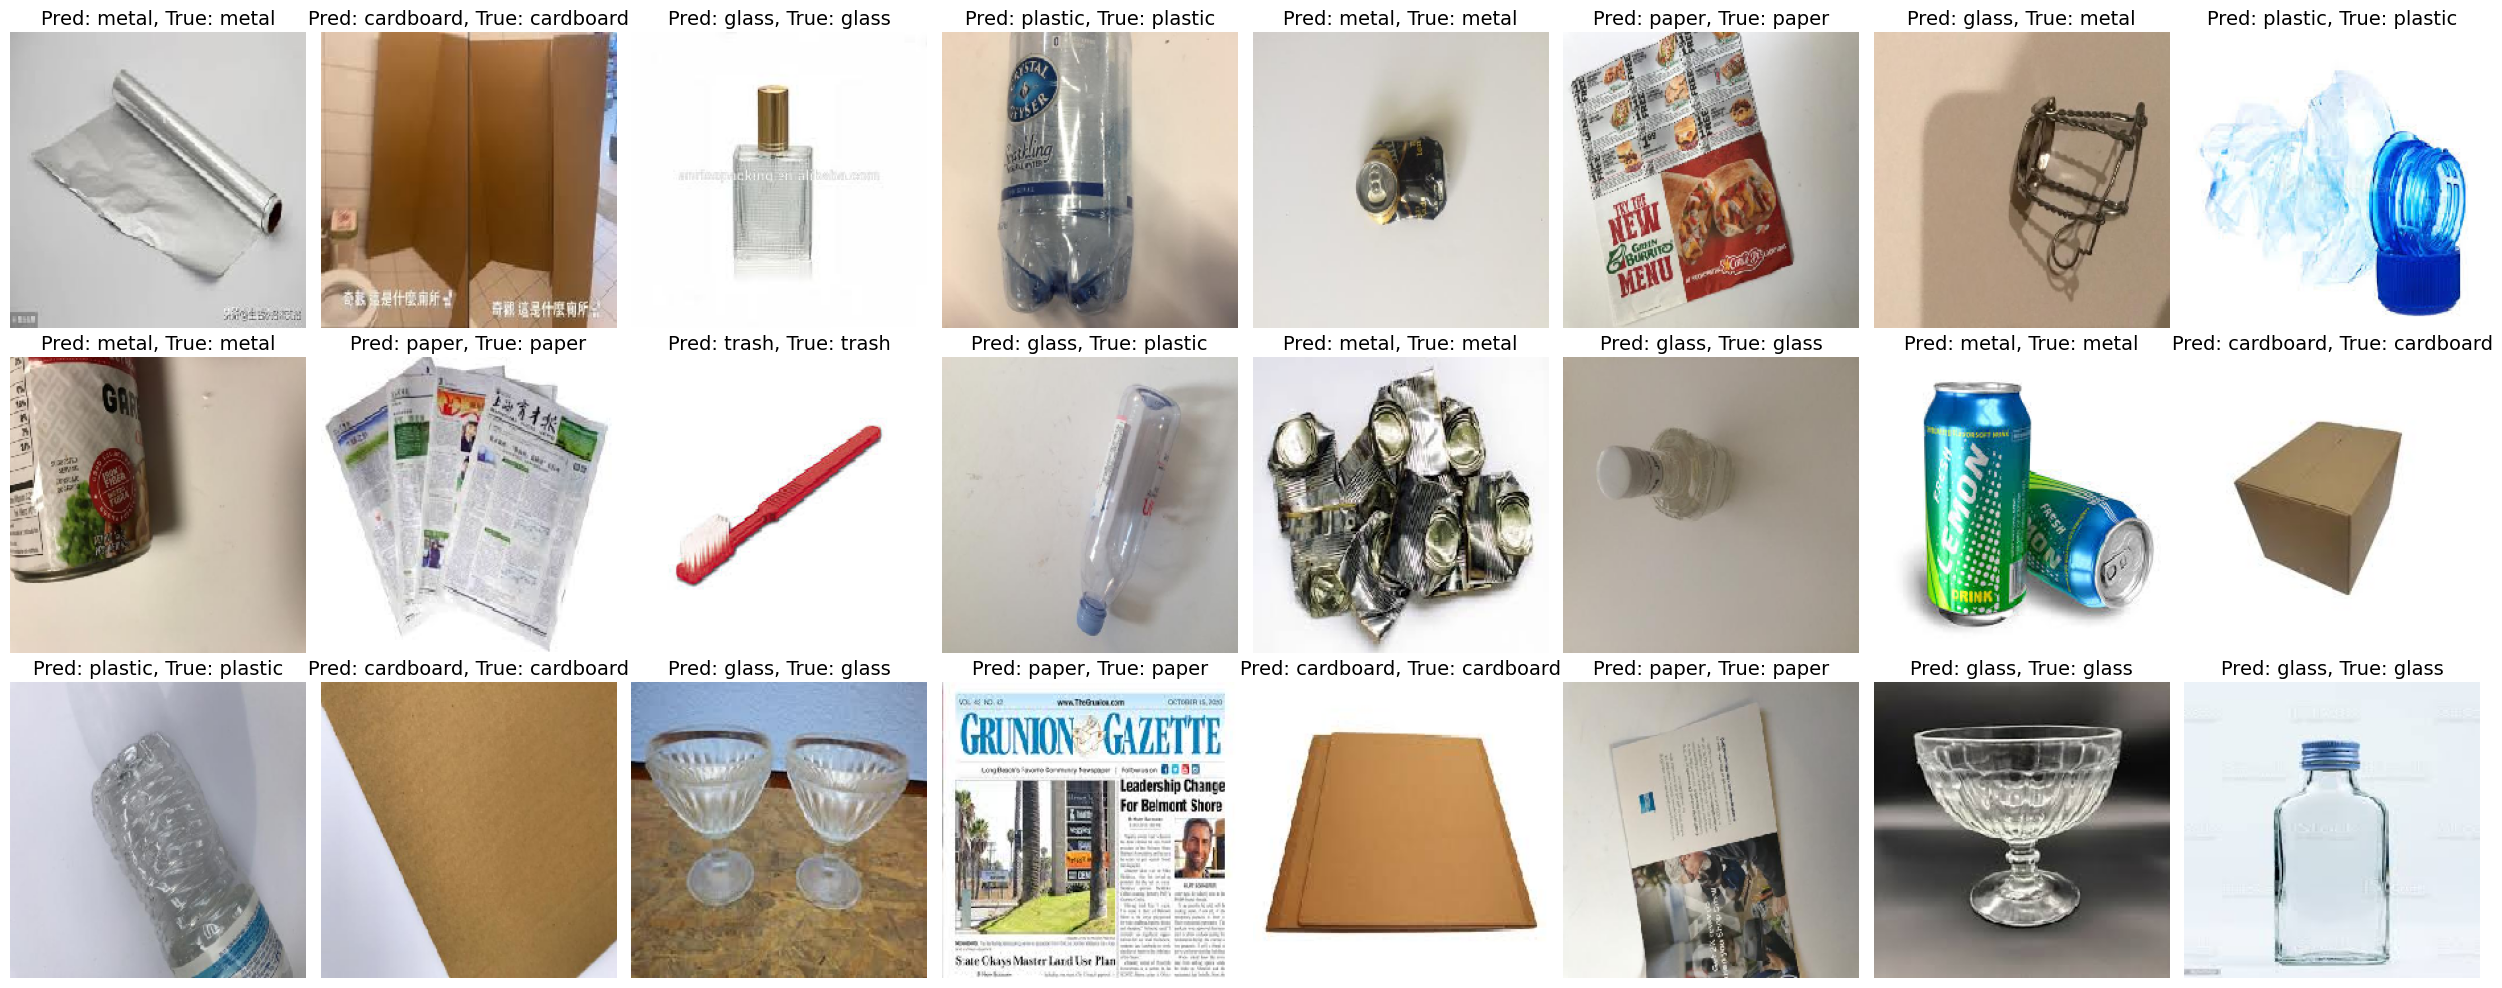

In [33]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()